# Clean Users Analysis

Users are scraped using the `baseline-user-ids.json` input (a list of User IDs) in `twitter_scraper.scrape` - at this point, Users' locations aren't restricted to Croatia only as they will be filtered using the `twitter_scraper.clean` module.

This module reads the scraped User data and filters it by:

* *protected* = False
* *is_croatian* = True
* *statuses_count* > 10
* *friends_count* > 10
* *friends_count* < 5000
* *followers_count* > 10
* *followers_count* < 5000

Resulting with the following data schema:

Column           | Description                                                          | Data Type   
---------------- | -------------------------------------------------------------------- | ------- 
user_id          | Numeric user identifier                                              | int64
created_at       | The UTC datetime that the user account was created on Twitter        | datetime64[ns, UTC]
screen_name      | Alphabetic user identifier                                           | string  
location         | User submitted location                                              | string  
description      | User submitted description                                           | string  
protected        | User allows public access to his profile                             | boolean 
verified         | User is verified by Twitter ([Verified Accounts](https://help.twitter.com/en/managing-your-account/about-twitter-verified-accounts))                                                       | boolean 
followers_count  | Number of accounts that follow the user                              | int64   
friends_count    | Number of accounts that the user follows                             | int64   
listed_count     | Number of public lists that this user is a member of                 | int64   
favourites_count | The number of Tweets this user has liked in the account's lifetime   | int64   
statuses_count   | The number of Tweets (including retweets) issued by the user         | int64   
is_croatian      | Custom value indicating the user's location is Croatian              | bool    
clean_location   | Custom value, aims to pinpoint a Croatian location                   | string  

## Interpreting Croatian Twitter Users

The "Clean Users Analysis" answers the following questions:

* What is the most common Croatian Users location?
* Who are Croatian Users that tweet the most (all-time number of tweets)? Are they verified?
* Which Croatian users are followed the most? 
* Which Croatian users like other tweets the most?

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.style

mpl.style.use('seaborn-v0_8-darkgrid')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
from preproc import ANALYSIS_COLUMNS

import datetime as dt
import pandas as pd

USER_DISPLAY_NAME = 'user_id'
ANALYSIS_START_DATE = dt.datetime.fromisoformat('2022-11-01T00:00:00+00:00')
ANALYSIS_END_DATE = dt.datetime.fromisoformat('2022-11-30T23:59:59+00:00')

users_df = pd.read_csv('preproc_users_view.csv', index_col='user_id')
tweets_view = pd.read_csv('preproc_tweets_view.csv', parse_dates=['created_at'])
tweets_view = tweets_view[
    (tweets_view.created_at >= ANALYSIS_START_DATE)
    & (tweets_view.created_at <= ANALYSIS_END_DATE)
]

users_view = users_df.loc[tweets_view.user_id.unique()].copy()
users_view = users_view[ANALYSIS_COLUMNS['users']]

users_view['hashtags'] = users_view['hashtags'].map(eval)
users_view['original_hashtags'] = users_view['original_hashtags'].map(eval)
users_view['retweet_hashtags'] = users_view['retweet_hashtags'].map(eval)
users_view['quote_hashtags'] = users_view['quote_hashtags'].map(eval)

users_view['user_mentions'] = users_view['user_mentions'].map(eval)
users_view['original_user_mentions'] = users_view['original_user_mentions'].map(eval)
users_view['retweet_user_mentions'] = users_view['retweet_user_mentions'].map(eval)
users_view['quote_user_mentions'] = users_view['quote_user_mentions'].map(eval)

stats_df = pd.DataFrame(
    [
        '{:,}'.format(len(users_df[users_df.is_croatian == True])),
        '{:,}'.format(len(tweets_view.user_id.unique())),
        '{:,}'.format(len(tweets_view)),
        
        '{0:.2f}%'.format(100*(users_view['original_tweets_cnt'].sum() / (users_view['original_tweets_cnt'].sum() + users_view['out_retweet_cnt'].sum()))),
        '{0:.2f}%'.format(100*(users_view['out_retweet_cnt'].sum()     / (users_view['original_tweets_cnt'].sum() + users_view['out_retweet_cnt'].sum()))),
        
        '{:,}'.format(users_view['original_tweets_cnt'].sum()),
        '{:,}'.format(users_view['out_retweet_cnt'].sum()),
        '{:,}'.format(users_view['out_reply_cnt'].sum()),
        '{:,}'.format(users_view['out_quote_cnt'].sum()),
        
        '{:,}'.format(users_view['in_retweet_cnt'].sum()),
        '{:,}'.format(users_view['in_reply_cnt'].sum()),
        '{:,}'.format(users_view['in_quote_cnt'].sum()),
        
        tweets_view.created_at.min(),
        tweets_view.created_at.max()

    ],
    index=[
        "Croatian Users (global) #",
        "Croatian Users (tweets) #",
        "Tweets #",
        
        "Original %",
        "Reweets %",
        
        "Original #",
        "Reweets #",
        "Replies #",
        "Quotes #",
        
        "In Reweets #",
        "In Replies #",
        "In Quotes #",
        
        "Earliest Tweet date",
        "Latest Tweet date"
    ],
    columns=['Tweets Data']
)

stats_df

,Tweets Data
Croatian Users (global) #,"48,954"
Croatian Users (tweets) #,"6,887"
Tweets #,"386,168"
Original %,68.71%
Reweets %,31.29%
Original #,"656,610.0"
Reweets #,"298,997.0"
Replies #,"408,943.0"
Quotes #,"61,251.0"
In Reweets #,"18,396.0"


In [5]:
users_view[users_view['screen_name'] == 'HNS_CFF'].iloc[0]

screen_name                                                             HNS_CFF
name                                                                        HNS
verified                                                                   True
lemmatized_text               ['day', 'office', 'Antonio', 'mirko', 'čolak',...
location                                                     Hrvatska | Croatia
clean_location                                                         Hrvatska
description                   Službeni Twitter profil Hrvatskog nogometnog s...
is_croatian                                                                True
followers_count                                                          253625
friends_count                                                               117
favourites_count                                                            476
total_out_tweets_cnt                                                      779.0
original_tweets_cnt                     

In [6]:
import numpy as np

def df_format_decimal(df):
    format_df = df.copy()
    for col_name in df.columns:
        format_df.loc[:, col_name] = format_df[col_name].transform(lambda x: '{0:,}'.format(x))
    return format_df

df_format = users_view.select_dtypes(include=np.number).describe(percentiles=[.3, .6, .9]).transpose().round(2)
df_format['count'] = df_format['count'].astype(int)
df_format = df_format.drop('50%', axis=1)

df_format_decimal(df_format)#.style.to_latex(open('descriptive-statistics.tex', 'w'))

,count,mean,std,min,30%,60%,90%,max
followers_count,"6,887","1,408.73","21,214.16",11.0,68.0,262.0,"1,662.8","1,541,746.0"
friends_count,"6,887",568.93,751.9,11.0,168.0,410.0,"1,334.6","5,002.0"
favourites_count,"6,887","12,972.38","35,157.7",0.0,632.8,"3,893.0","31,763.4","832,761.0"
total_out_tweets_cnt,"6,887",138.76,396.97,1.0,7.0,34.0,320.0,"5,342.0"
original_tweets_cnt,"6,887",95.34,298.68,0.0,3.0,19.0,211.0,"5,337.0"
out_retweet_cnt,"6,887",43.41,216.0,0.0,0.0,5.0,65.0,"5,093.0"
out_reply_cnt,"6,887",59.38,221.26,0.0,1.0,7.0,127.0,"5,180.0"
out_quote_cnt,"6,887",8.89,48.69,0.0,0.0,1.0,15.0,"1,479.0"
total_in_tweets_cnt,"6,887",16.18,75.21,0.0,0.0,1.0,28.0,"1,844.0"
in_retweet_cnt,"6,887",2.67,22.95,0.0,0.0,0.0,3.0,"1,266.0"


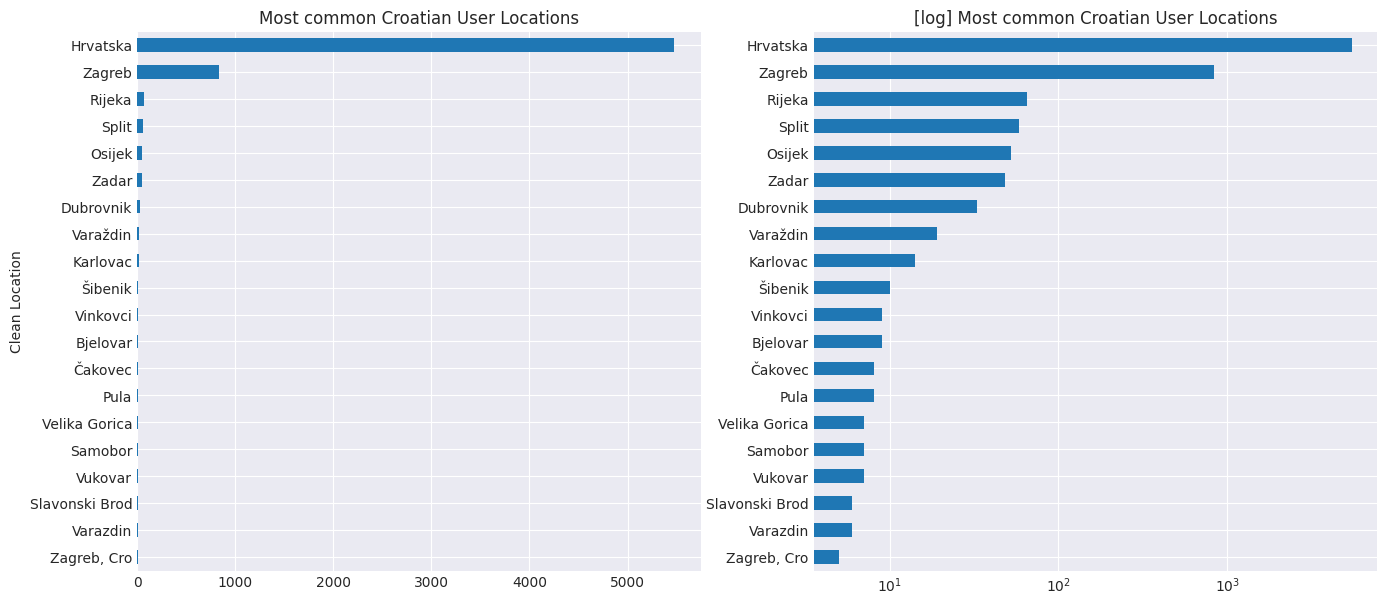

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

location_df = users_view.groupby('clean_location').size().sort_values()
# location_df.drop(['Hrvatska', '🇭🇷', 'Zg'], inplace=True)
location_df.tail(20).plot.barh(ax=axs[0])

axs[0].set_title('Most common Croatian User Locations')
axs[0].set_ylabel('Clean Location')

location_df.tail(20).plot.barh(ax=axs[1])

axs[1].set_title('[log] Most common Croatian User Locations')
axs[1].set_ylabel(None)
axs[1].set_xscale('log')
plt.show()

In [18]:
import warnings
warnings.simplefilter(action = "ignore", category = UserWarning)


PLOT_CONFIG = {
    'plot_head': 12,
    'inbound_cols': {
        'in_retweet_cnt': 'Retweeted', 
        'in_reply_cnt': 'Replied', 
        'in_quote_cnt': 'Quoted'
    },
    'outbound_cols': {
        # 'out_retweets_cnt': 'Retweet', 
        # 'out_replies_cnt': 'Reply', 
        # 'out_quotes_cnt': 'Quote',
        'original_tweets_cnt': 'Original'
    },
    'total_cols': {
        'total_out_tweets_cnt': 'Total number of Outgoing Reactions',
        'total_in_tweets_cnt': 'Total number of Incoming Reactions'
    }
}

rename_map = dict(PLOT_CONFIG['inbound_cols'], **PLOT_CONFIG['outbound_cols'])

def plot_top_tweet_users(df, title, max_x, export_plot_name=None):
    fig, ax = plt.subplots(1, figsize=(14, 8))

    top_tweets_df = df[
        ['original_tweets_cnt', 
        #  'out_retweet_cnt', 'out_reply_cnt', 'out_quote_cnt', 
         'in_retweet_cnt', 'in_reply_cnt', 'in_quote_cnt' ]
    ].copy()

    top_tweets_df['original_tweets_cnt'] = top_tweets_df['original_tweets_cnt'] * -1
    # top_tweets_df['out_retweet_cnt'] = top_tweets_df['out_retweet_cnt'] * -1
    # top_tweets_df['out_reply_cnt'] = top_tweets_df['out_reply_cnt'] * -1
    # top_tweets_df['out_quote_cnt'] = top_tweets_df['out_quote_cnt'] * -1
    
    rename_map = dict(PLOT_CONFIG['inbound_cols'], **PLOT_CONFIG['outbound_cols'])
    top_tweets_df = top_tweets_df.rename(columns=rename_map)
    
    x1000 = max_x % 1000
    max_x = ((max_x-x1000) // 1000) * 1000 + 1000
    min_x = max_x * -1
    
    inbound_cols = PLOT_CONFIG['inbound_cols'].values()
    outbound_cols = PLOT_CONFIG['outbound_cols'].values()
    
    top_tweets_df[outbound_cols].plot.barh(
        ax=ax, 
        # alpha=0.5,
        stacked=True,
        color={
            'Original': default_colors[0], 
            # 'Retweet': default_colors[1], 
            # 'Reply': default_colors[2], 
            # 'Quote': default_colors[3]
        }
    )
    legend_1 = plt.legend(outbound_cols, loc='lower left')
    # for i, color in enumerate(default_colors[1:len(outbound_cols)-1]):
    #     legend_1.legendHandles[i].set_color(color)
    legend_1.legendHandles[0].set_color(default_colors[0])


    top_tweets_df[inbound_cols].plot.barh(
        ax=ax,
        stacked=True,
        color={
            'Retweeted': default_colors[1], 
            'Replied': default_colors[2], 
            'Quoted': default_colors[3]
        }
    )
    legend_2 = plt.legend(inbound_cols, loc='lower right')
    for i, color in enumerate(default_colors[1:len(inbound_cols)+1]):
        legend_2.legendHandles[i].set_color(color)
    
    ax.add_artist(legend_1)
    ax.add_artist(legend_2)
    ax.set_title(title)
    ax.set_xlabel('Tweet Count')
    ax.set_ylabel('User Name')
    ax.set_xlim(min_x, max_x)
    ticks = ax.get_xticks()
    ax.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax.axvline(color='red')

    # plt.xticks(rotation=30)
    
    if export_plot_name:
        plt.savefig(export_plot_name, format='eps', dpi=200)    
    
    plt.show()
    

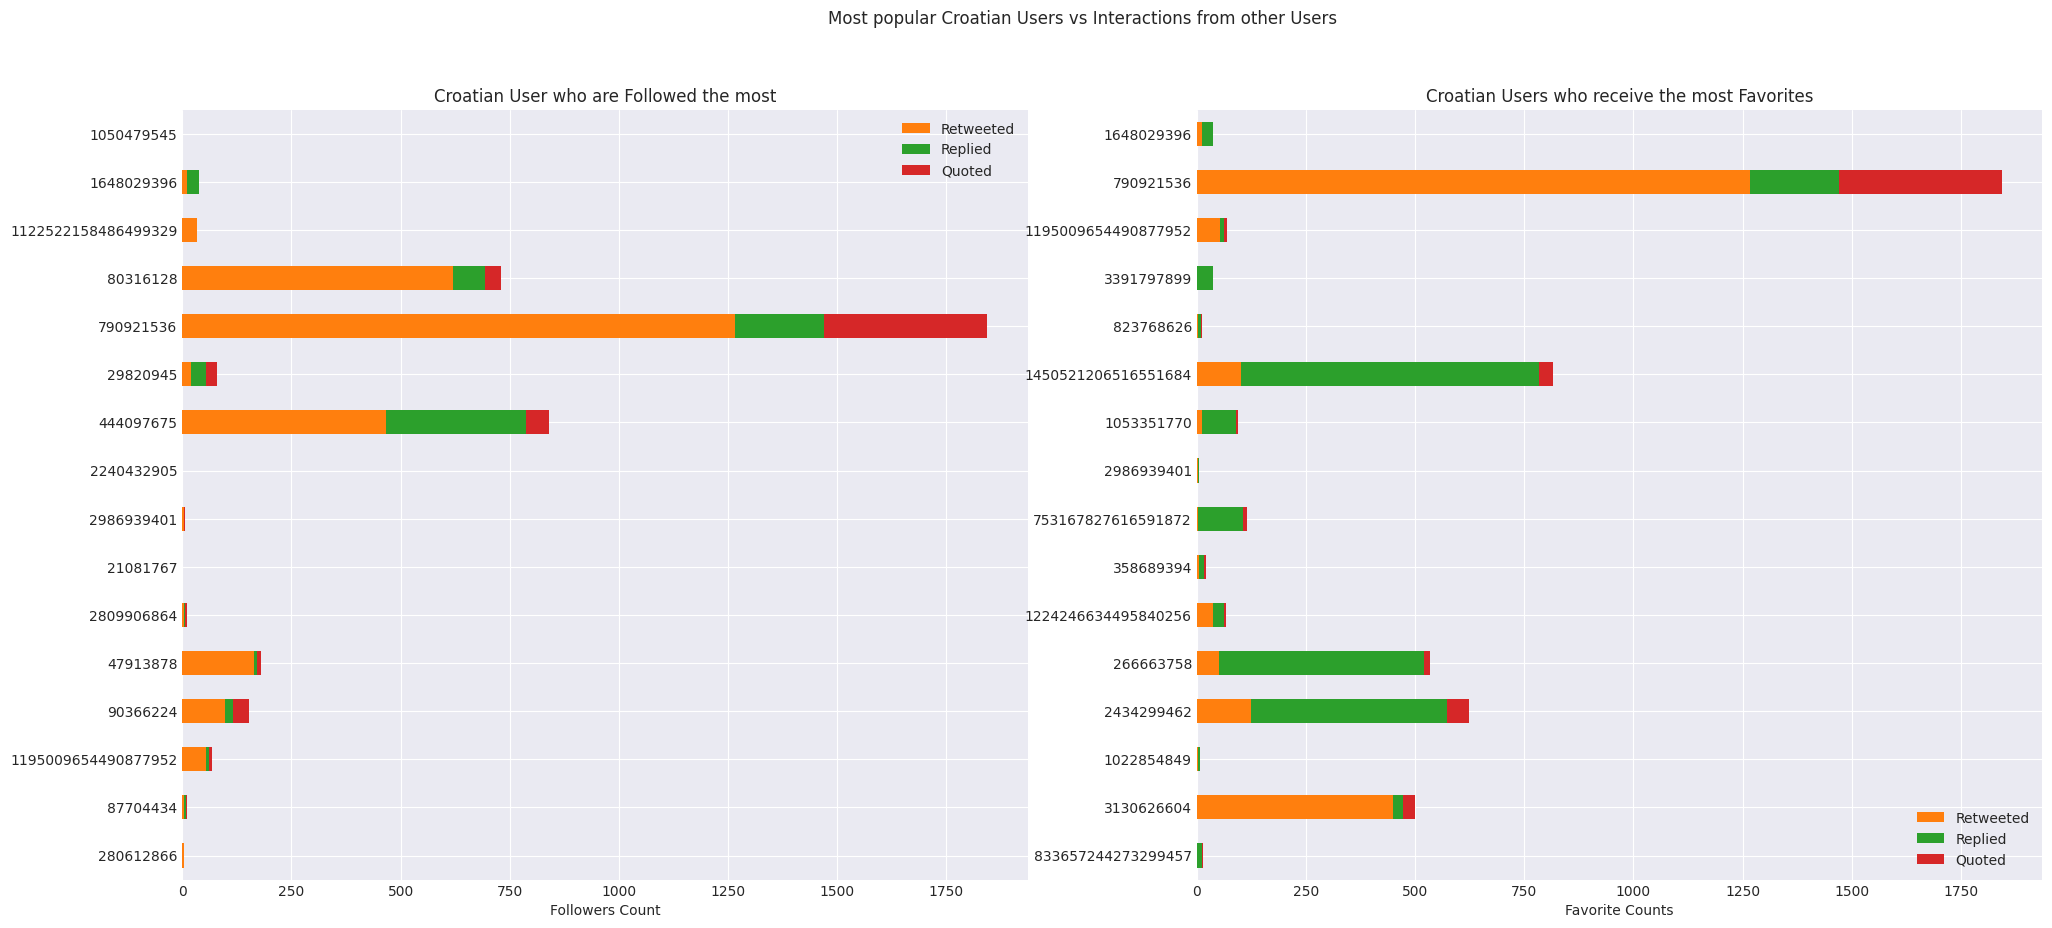

In [19]:
top = 16

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))

plt.suptitle('Most popular Croatian Users vs Interactions from other Users')

top_followed_users = users_view[
  ['name', 'description', 'followers_count', 'in_retweet_cnt', 'in_reply_cnt', 'in_quote_cnt']#, USER_DISPLAY_NAME]
].sort_values(by='followers_count', ascending=True).tail(top)

top_followed_users[
  ['in_retweet_cnt', 'in_reply_cnt', 'in_quote_cnt']
].rename(
  columns=rename_map
).plot.barh(
  ax=ax[0], 
  stacked=True, 
  color={
    'Retweeted': default_colors[1], 
    'Replied': default_colors[2], 
    'Quoted': default_colors[3]
})

# top_followed_users[['followers_count']].plot.barh(ax=ax[0])

ax[0].set_title('Croatian User who are Followed the most')
ax[0].set_xlabel('Followers Count')
ax[0].set_ylabel(None)

top_in_favorite_cnt_users = users_view[
  ['name', 'description', 'in_original_favorite_cnt', 'in_retweet_cnt', 'in_reply_cnt', 'in_quote_cnt']#, USER_DISPLAY_NAME]
].sort_values(by='in_original_favorite_cnt', ascending=True).tail(top)

top_in_favorite_cnt_users[
  ['in_retweet_cnt', 'in_reply_cnt', 'in_quote_cnt']
].rename(
  columns=rename_map
).plot.barh(
  ax=ax[1], 
  stacked=True, 
  color={
    'Retweeted': default_colors[1], 
    'Replied': default_colors[2], 
    'Quoted': default_colors[3]
})

ax[1].set_title('Croatian Users who receive the most Favorites')
ax[1].set_xlabel('Favorite Counts')
ax[1].set_ylabel(None)

plt.show()

# display(top_followed_users[['name', 'description']].iloc[::-1])

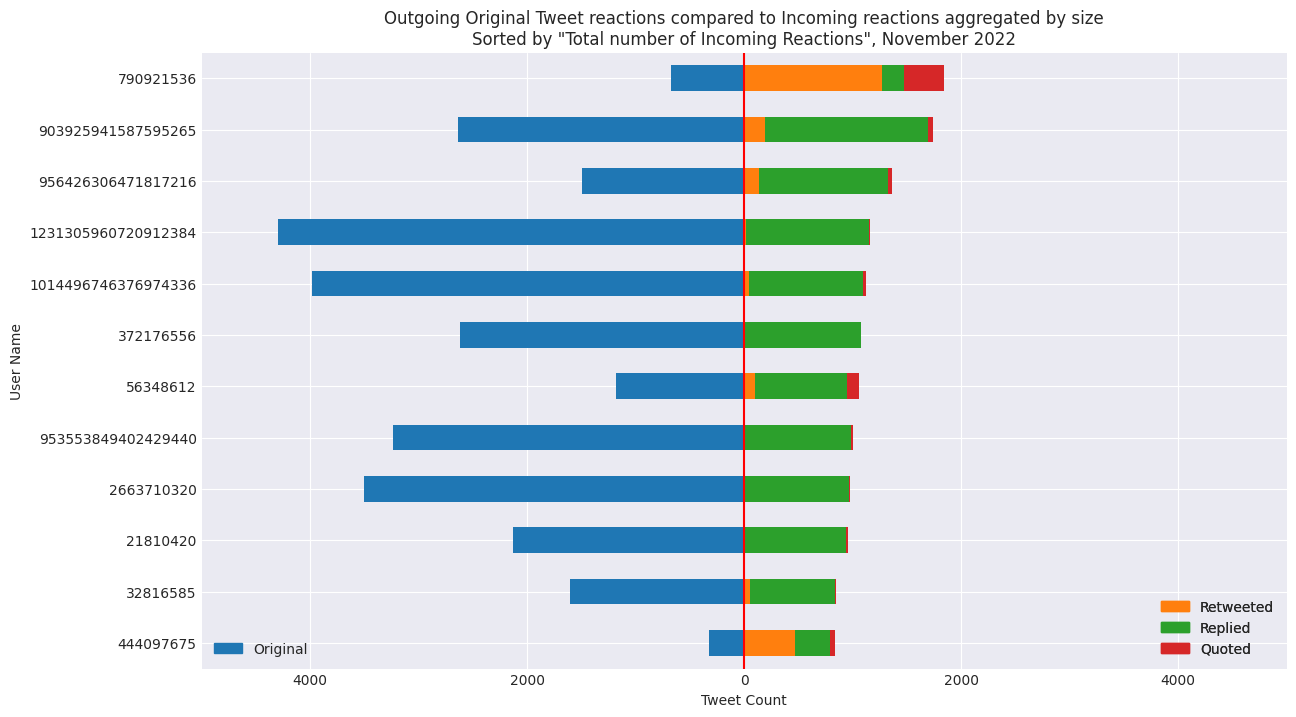

In [20]:
sorted_by = 'total_in_tweets_cnt'

top_total_in_tweets_users = users_view.sort_values(by=sorted_by, ascending=False).head(PLOT_CONFIG['plot_head'])[::-1]
MAX_X = top_total_in_tweets_users.original_tweets_cnt.max() + (top_total_in_tweets_users.original_tweets_cnt.max() * .1)

plot_top_tweet_users(
    top_total_in_tweets_users, 
    title=(
        'Outgoing Original Tweet reactions compared to Incoming reactions aggregated by size\n'
        'Sorted by "{}", November 2022'
    ).format(PLOT_CONFIG['total_cols'][sorted_by]),
    max_x=MAX_X,
    export_plot_name='eps/users-total-in-initiators.eps'
)

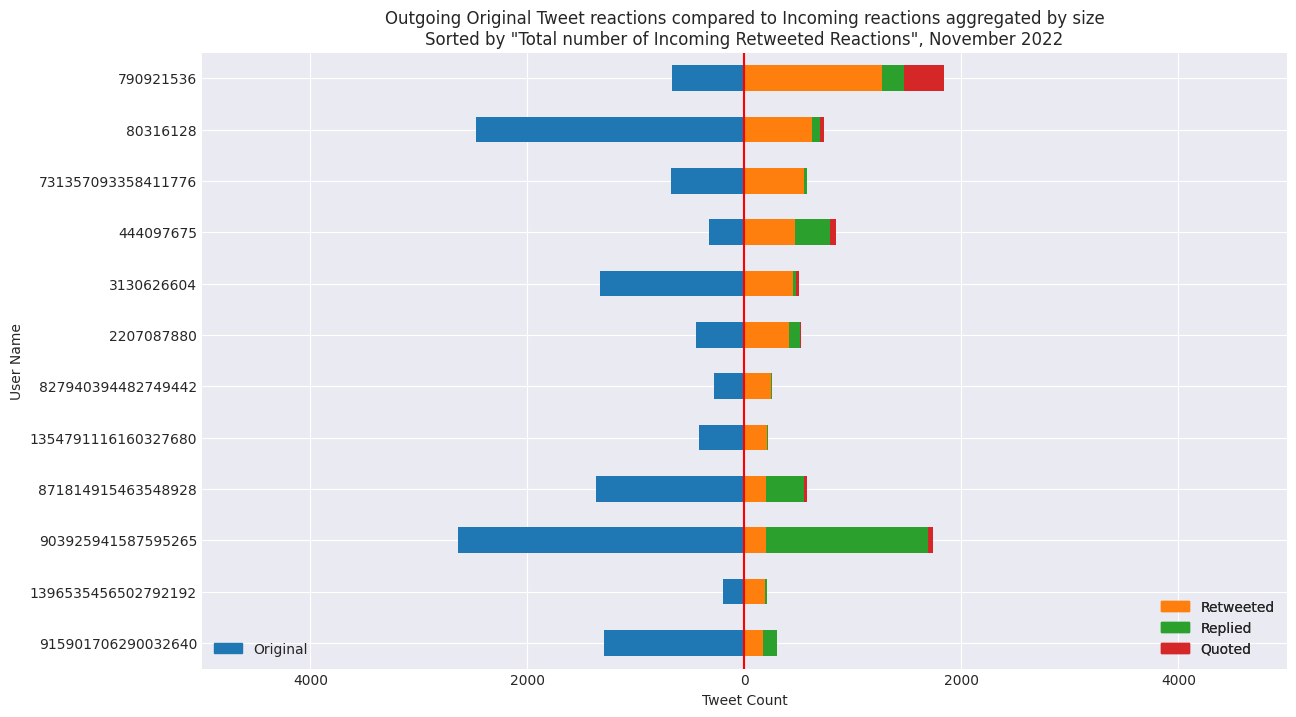

In [24]:
sorted_by = 'in_retweet_cnt'
top_in_retweet_users = users_view.sort_values(by=sorted_by, ascending=False).head(PLOT_CONFIG['plot_head'])[::-1]
plot_top_tweet_users(
    top_in_retweet_users, 
    title=(
        'Outgoing Original Tweet reactions compared to Incoming reactions aggregated by size\n'
        'Sorted by "Total number of Incoming {} Reactions", November 2022'
    ).format(PLOT_CONFIG['inbound_cols'][sorted_by]),
    max_x=MAX_X,
    export_plot_name='eps/users-retweet-in-initiators.eps'
)

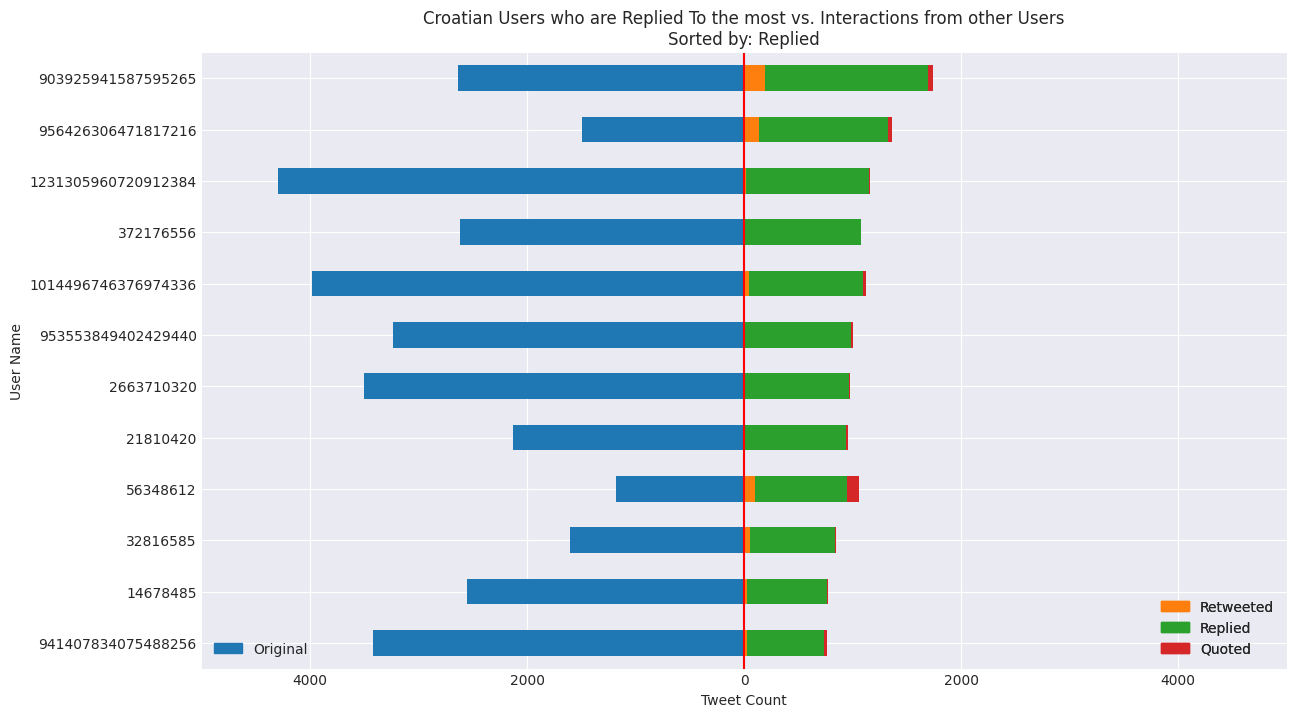

In [ ]:
sorted_by = 'in_reply_cnt'
top_in_reply_users = users_view.set_index(USER_DISPLAY_NAME).sort_values(by=sorted_by, ascending=False).head(PLOT_CONFIG['plot_head'])[::-1]
plot_top_tweet_users(
    top_in_reply_users, 
    title=(
        'Croatian Users who are Replied To the most '
        'vs. Interactions from other Users\n'
        'Sorted by: {}'
    ).format(PLOT_CONFIG['positive_cols'][sorted_by]), 
    max_x=MAX_X,
    # export_plot_name='eps/users-interaction-initiators-replies.eps'
)

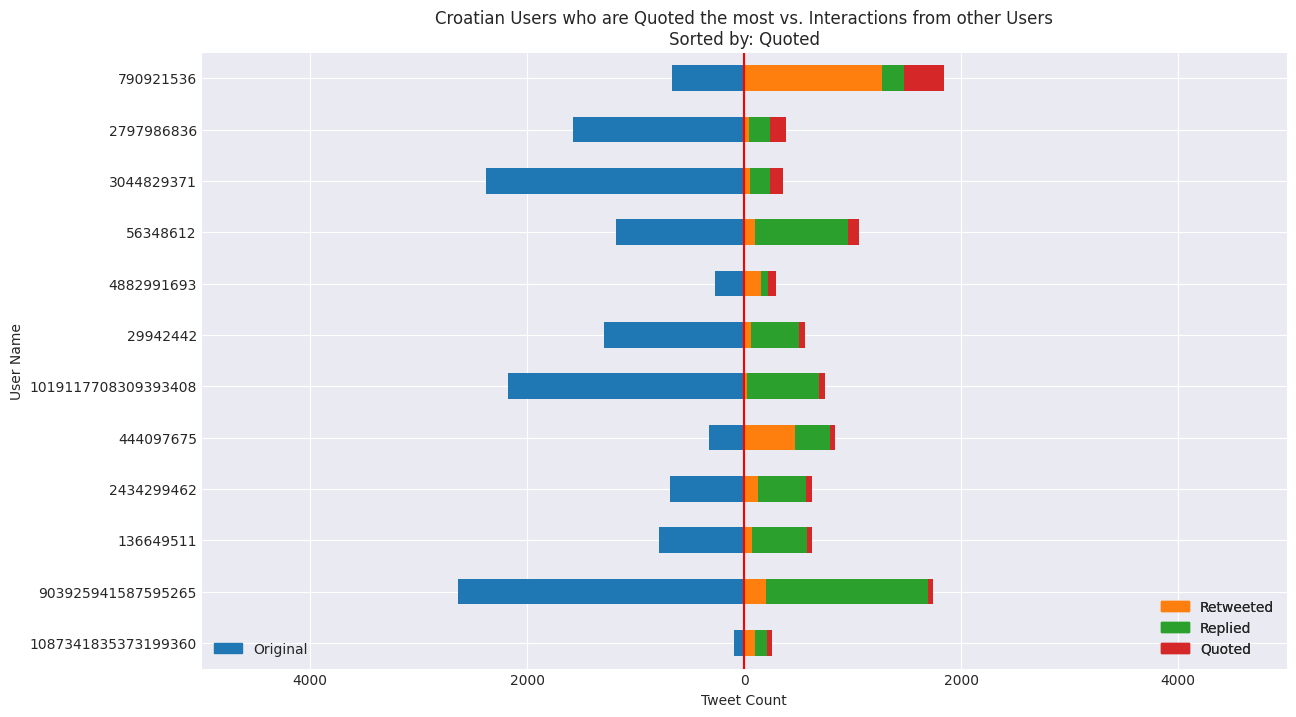

In [ ]:
sorted_by = 'in_quote_cnt'
top_in_quote_users = users_view.set_index(USER_DISPLAY_NAME).sort_values(by=sorted_by, ascending=False).head(PLOT_CONFIG['plot_head'])[::-1]
plot_top_tweet_users(
    top_in_quote_users, 
    title=(
        'Croatian Users who are Quoted the most '
        'vs. Interactions from other Users\n'
        'Sorted by: {}').format(PLOT_CONFIG['positive_cols'][sorted_by]), 
    max_x=MAX_X
)

[WARNING] 2022-12-11 19:38:07 matplotlib.backends.backend_ps - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


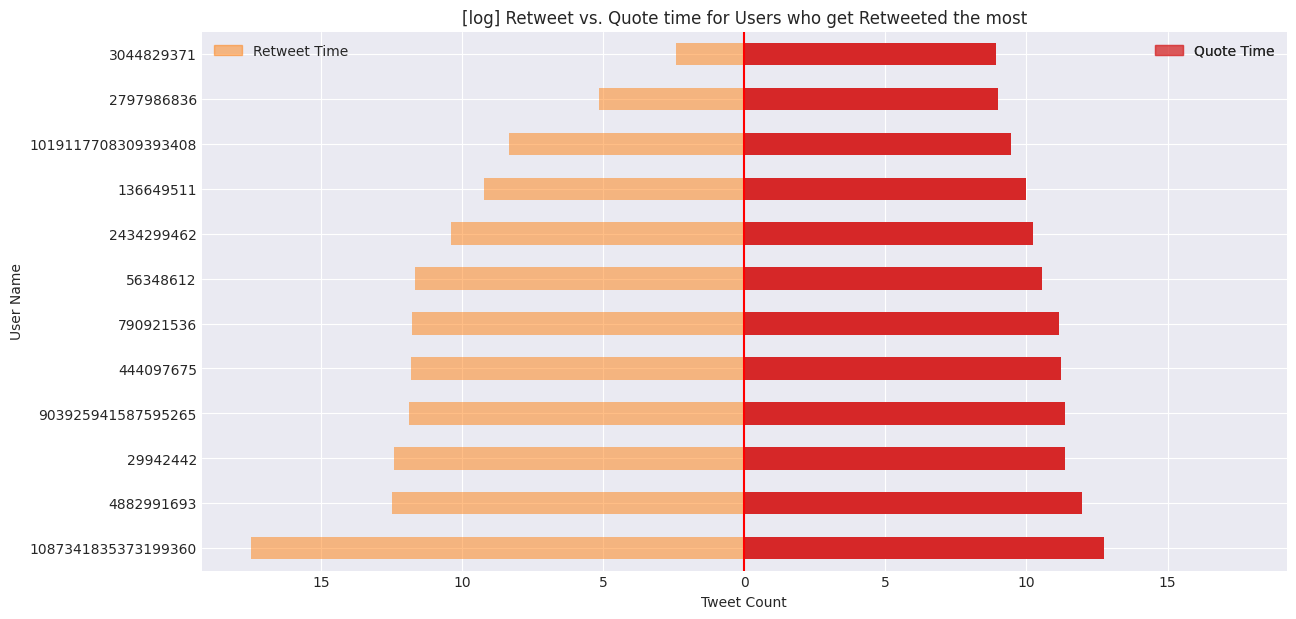

In [ ]:
import numpy as np
# np.log2(fastest_retweeted_users['quote_timedelta_sec'])
fig, ax = plt.subplots(1, figsize=(14, 7))

fastest_retweeted_users = users_view.set_index(USER_DISPLAY_NAME).sort_values(by='in_retweet_cnt').tail(PLOT_CONFIG['plot_head']).sort_values('in_retweet_timedelta_sec')
fastest_retweeted_users = fastest_retweeted_users[['in_retweet_timedelta_sec']].dropna()[::-1]
fastest_retweeted_users['in_retweet_timedelta_sec'] = (np.log2(fastest_retweeted_users['in_retweet_timedelta_sec'])*-1)

fastest_quoted_users = users_view.set_index(USER_DISPLAY_NAME).sort_values(by='in_quote_cnt').tail(PLOT_CONFIG['plot_head']).sort_values('in_quote_timedelta_sec')
fastest_quoted_users = fastest_quoted_users[['in_quote_timedelta_sec']].dropna()[::-1]
fastest_quoted_users['in_quote_timedelta_sec'] = np.log2(fastest_quoted_users['in_quote_timedelta_sec'])

fastest_retweeted_users.plot.barh(
    ax=ax, 
    alpha=0.5,
    stacked=True,
    color=default_colors[1]
)
legend_1 = plt.legend(['Retweet Time'], loc='upper left')
legend_1.legendHandles[0].set_color(default_colors[1])

fastest_quoted_users.plot.barh(ax=ax, stacked=True, color=default_colors[3])
legend_2 = plt.legend(['Quote Time'], loc='upper right')
legend_2.legendHandles[0].set_color(default_colors[3])

ax.add_artist(legend_1)
ax.add_artist(legend_2)
ax.set_title('[log] Retweet vs. Quote time for Users who get Retweeted the most')
ax.set_xlabel('Tweet Count')
ax.set_ylabel('User Name')
min_x = fastest_retweeted_users['in_retweet_timedelta_sec'].min() + (fastest_retweeted_users['in_retweet_timedelta_sec'].min() * .1)
ax.set_xlim(min_x, min_x*-1)
ax.axvline(color='red')
ticks = ax.get_xticks()
ax.set_xticklabels([int(abs(tick)) for tick in ticks])
plt.savefig('eps/users-interaction-retweet-timedelta.eps', format='eps', dpi=200)

# plt.xticks(rotation=30)
plt.show()


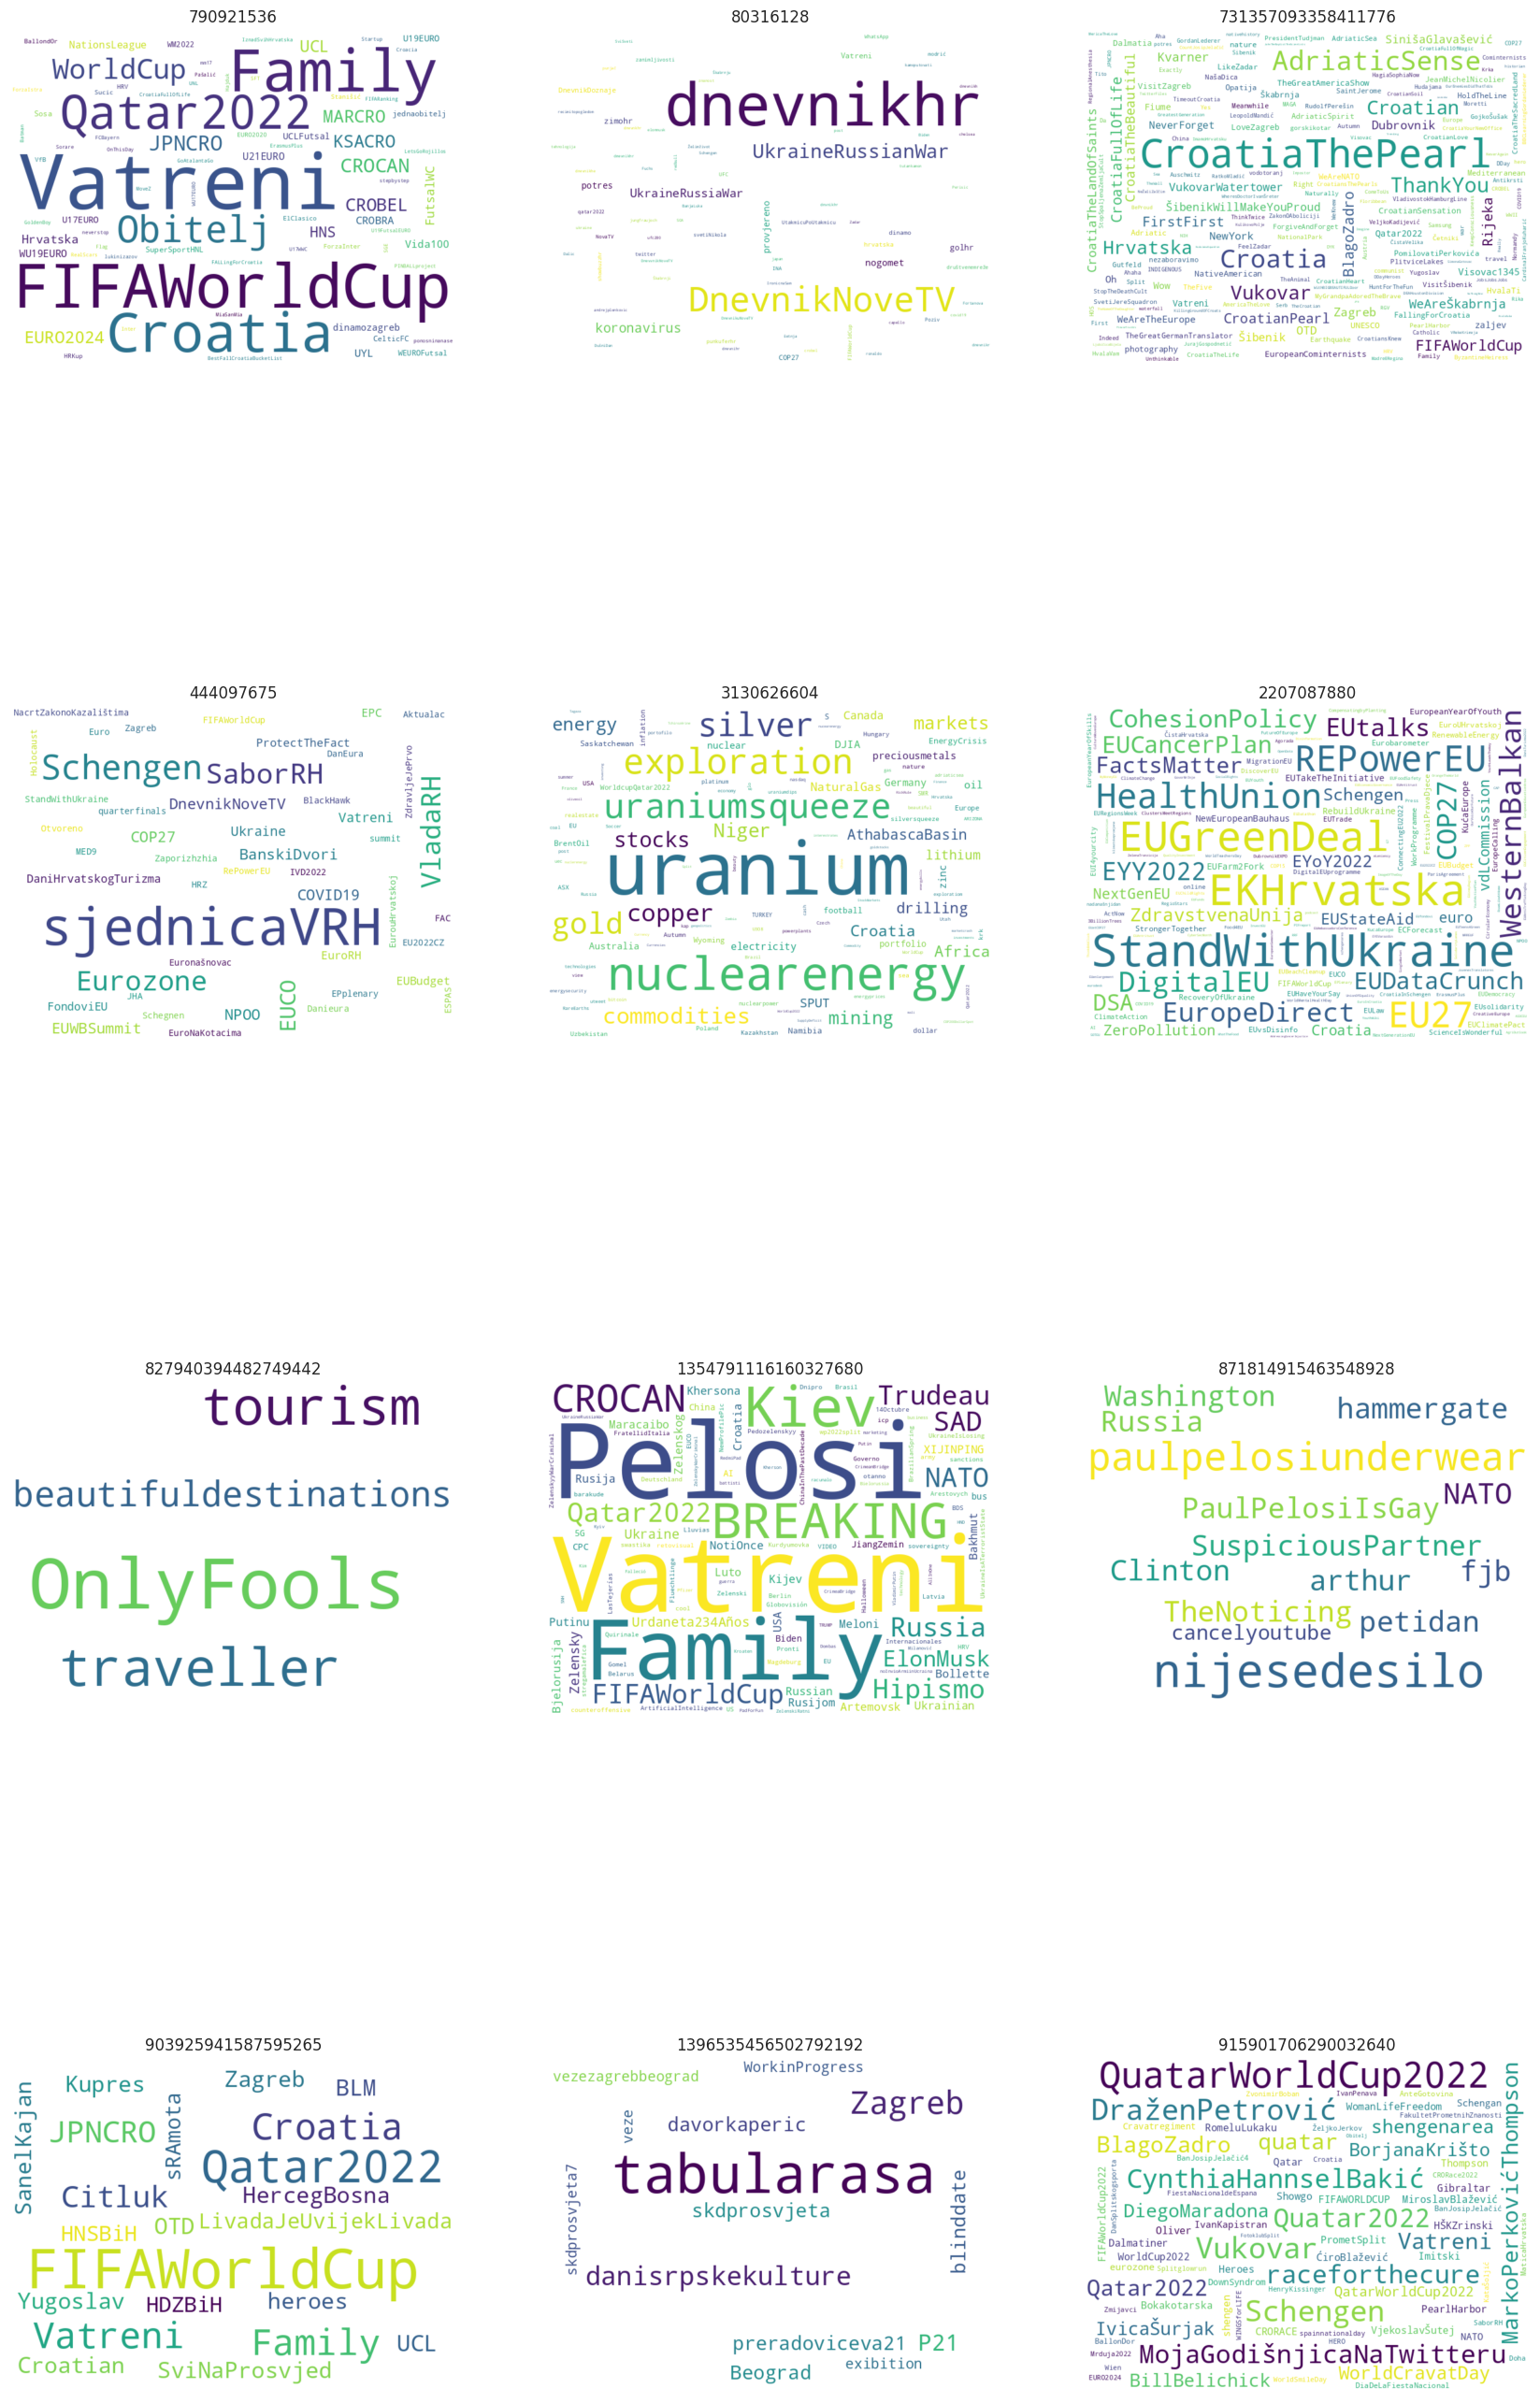

In [ ]:
from wordcloud import WordCloud
from math import ceil

ncols = 3
nrows = ceil(len(top_in_retweet_users) / ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*7, ncols*len(top_in_retweet_users)), squeeze=False)

i, j = 0, 0
for screen_name in top_in_retweet_users.index[::-1]:
    if j == ncols: j = 0; i += 1
    
    wordcloud_str = ' '.join(top_in_retweet_users.loc[screen_name].hashtags)
    wordcloud = WordCloud(
        collocations=False, 
        background_color='white', 
        width=720, 
        height=540, 
        margin=10
    ).generate(wordcloud_str)
    
    axs[i][j].imshow(wordcloud, interpolation='bilinear')
    axs[i][j].set_title(screen_name)
    axs[i][j].axis('off')

    j += 1
plt.show()

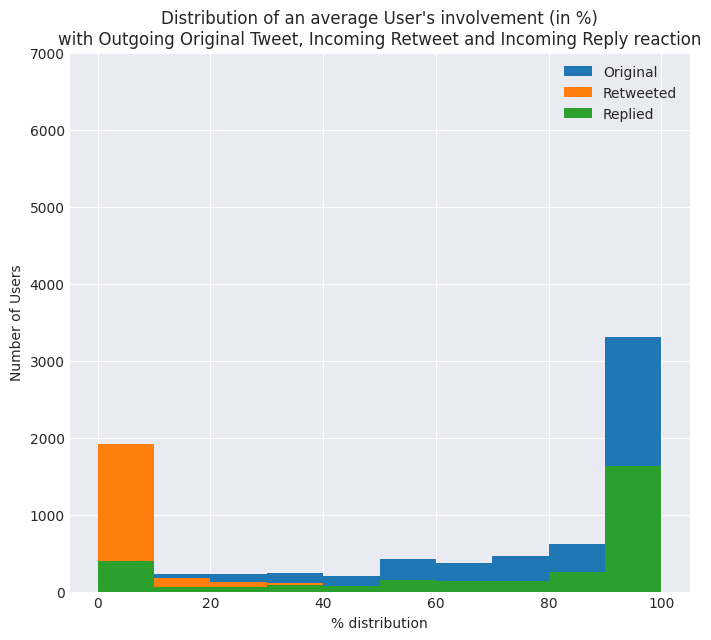

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 7), squeeze=False)

users_view['original_tweets_pct'] = 100*(users_view['original_tweets_cnt'] / users_view['total_out_tweets_cnt'])
users_view['in_retweet_pct'] = 100*(users_view['in_retweet_cnt'] / users_view['total_in_tweets_cnt'])
users_view['in_reply_pct'] = 100*(users_view['in_reply_cnt'] / users_view['total_in_tweets_cnt'])

users_view[['original_tweets_pct', 'in_retweet_pct', 'in_reply_pct']].plot.hist(ax=ax[0][0])

ax[0][0].set_title((
    'Distribution of an average User\'s involvement (in %)\n'
    'with Outgoing Original Tweet, Incoming Retweet and Incoming Reply reaction'))
ax[0][0].set_ylabel('Number of Users')
ax[0][0].set_xlabel('% distribution')
ax[0][0].legend(['Original', 'Retweeted', 'Replied'])
ax[0][0].set_ylim(0, 7000)

# users_view[['in_retweet_cnt', 'in_reply_cnt']].plot.hist(alpha=0.5, ax=ax[0][1], color={'in_retweet_cnt': default_colors[1], 'in_reply_cnt': default_colors[2]})
# # users_view['retweet_tweets_pct'].hist(ax=ax[0][1], log=False, color=default_colors[1])
# ax[0][1].set_title('Retweeted vs Replied To % distribution among Users')
# ax[0][1].set_ylabel('Num. of Users')
# ax[0][1].set_xlabel('% distribution')
# ax[0][1].legend(['Retweeted', 'Replied To'])

plt.savefig('eps/users-reaction-distribution.eps', format='eps', dpi=200)
plt.show()

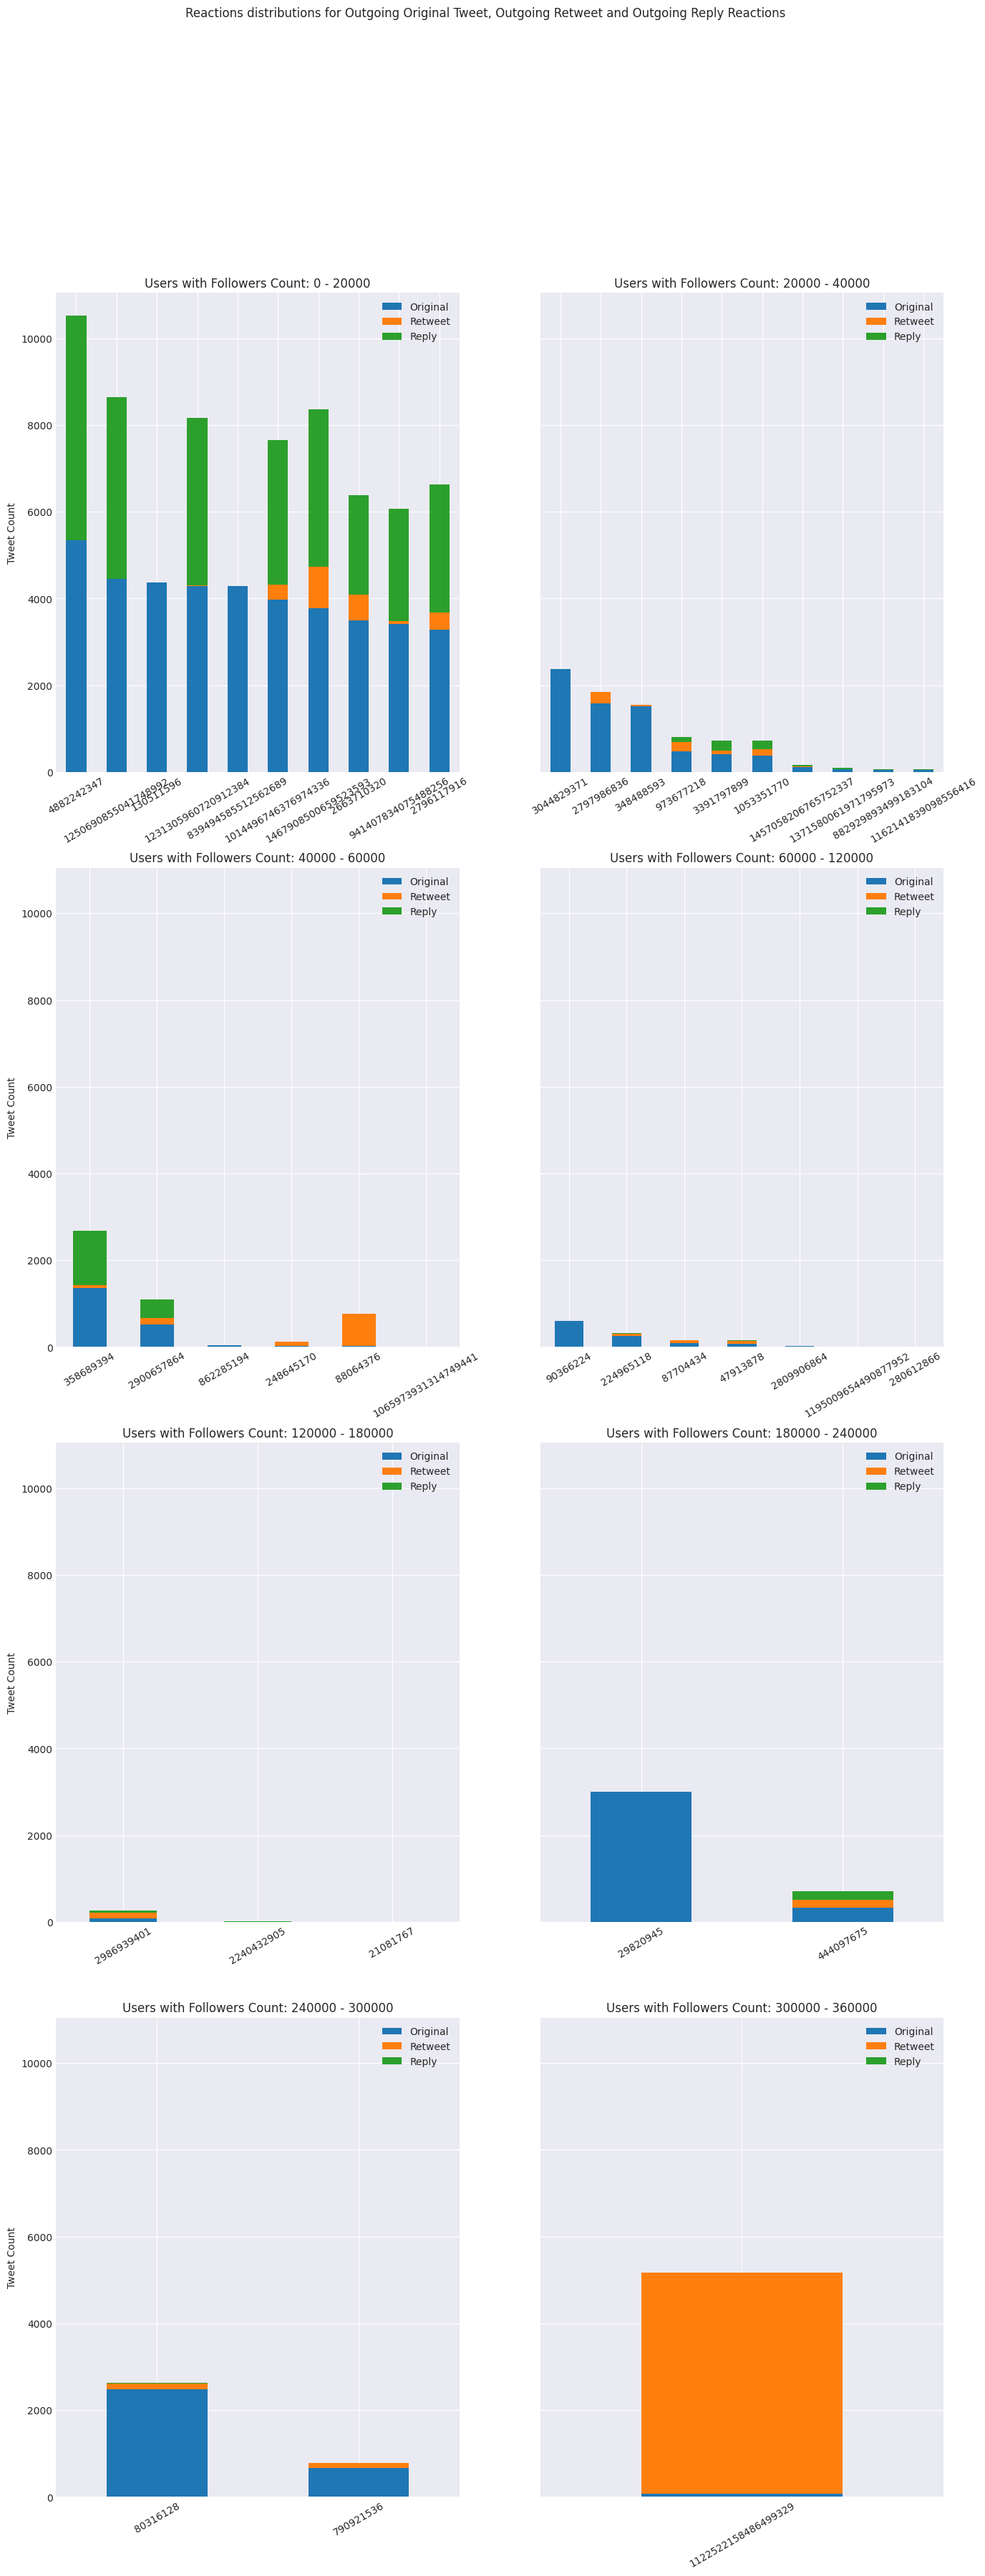

In [50]:
from math import ceil

title = 'Reactions distributions for Outgoing Original Tweet, Outgoing Retweet and Outgoing Reply Reactions'

upper_limit = 350_000
step_1 = 20_000
step_2 = 60_000

ncols = 2
nrows = ceil(step_2/step_1/ncols) + ceil(upper_limit/step_2/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows-1, sharey=True, figsize=(ncols*8, nrows*8))

plt.suptitle(title)

i, j = 0, 0
for limit in range(0, step_2, step_1):
    if j == ncols: j = 0; i += 1
    
    users_view[
        (users_view['followers_count'] > limit)
        & (users_view['followers_count'] < limit+step_1)
    ].sort_values('original_tweets_cnt', ascending=False)[
        ['original_tweets_cnt', 'out_retweet_cnt', 'out_reply_cnt']
    ].head(10).rename(
        columns={
            'original_tweets_cnt': 'Original',
            'out_retweet_cnt': 'Retweet',
            'out_reply_cnt': 'Reply'
        }
    ).plot.bar(rot=30, stacked=True, ax=axs[i][j])
    axs[i][j].set_title('Users with Followers Count: {} - {}'.format(limit, limit+step_1))
    axs[i][j].set_ylabel('Tweet Count')
    axs[i][j].set_xlabel(None)
    
    j += 1

for limit in range(step_2, upper_limit, step_2):
    if j == ncols: j = 0; i += 1
    
    if limit >= upper_limit:
        step = users_view.followers_count.max()
    
    users_view[
        (users_view['followers_count'] > limit)
        & (users_view['followers_count'] < limit+step_2)
    ].sort_values('total_out_tweets_cnt', ascending=False)[
        ['original_tweets_cnt', 'out_retweet_cnt', 'out_reply_cnt']
    ].head(10).rename(
        columns={
            'original_tweets_cnt': 'Original',
            'out_retweet_cnt': 'Retweet',
            'out_reply_cnt': 'Reply'
        }
    ).plot.bar(rot=30, stacked=True, ax=axs[i][j])
    axs[i][j].set_title('Users with Followers Count: {} - {}'.format(limit, limit+step_2))
    axs[i][j].set_ylabel('Tweet Count')
    axs[i][j].set_xlabel(None)
    
    j += 1

plt.savefig('eps/users-outgoing-reactions-by-followers-cnt.eps', format='eps', dpi=200)
plt.show()

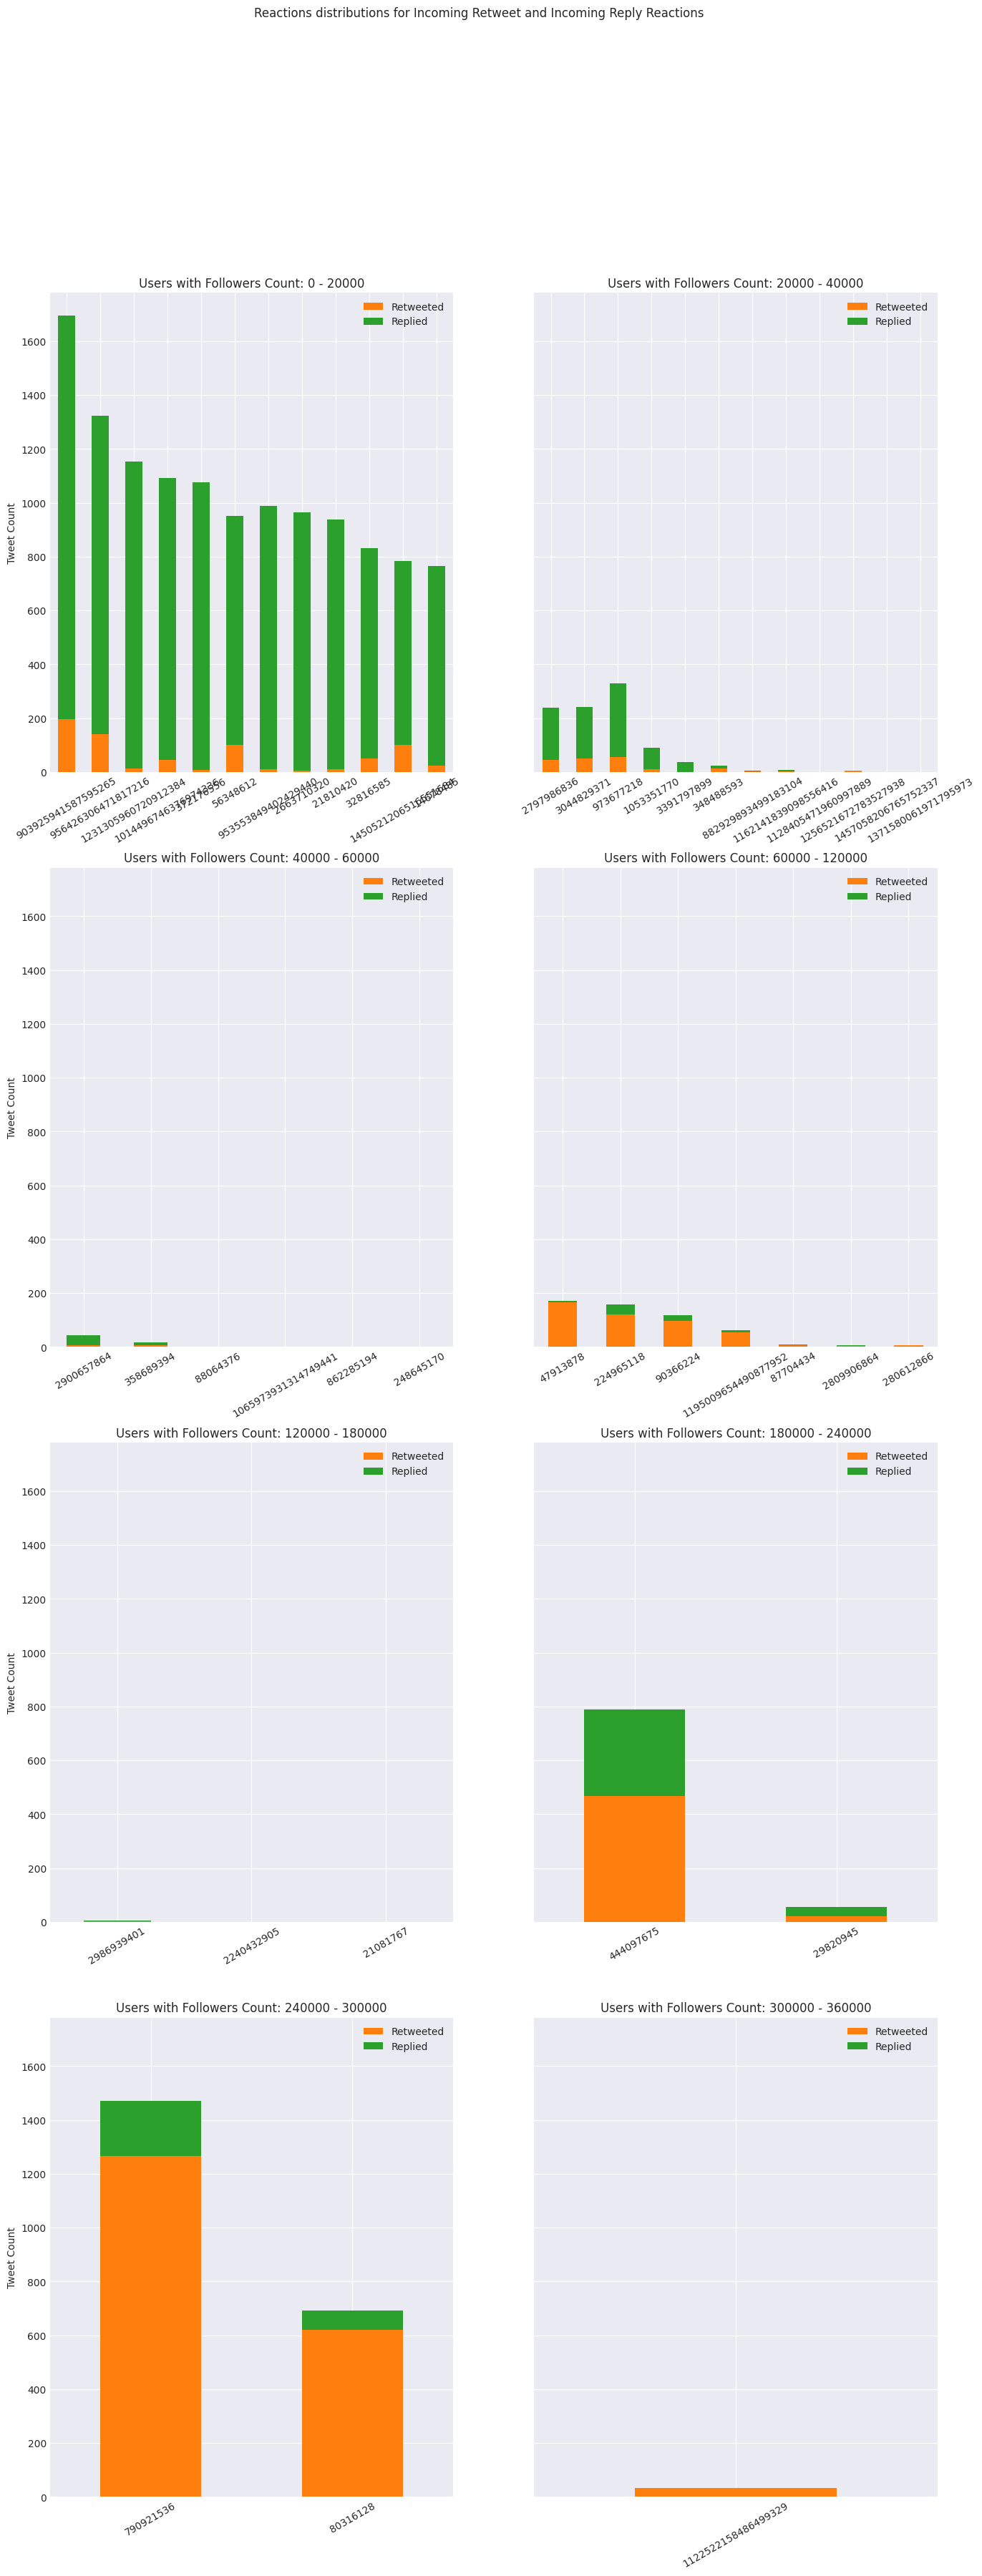

In [54]:
from math import ceil

title = 'Reactions distributions for Incoming Retweet and Incoming Reply Reactions'

upper_limit = 350_000
step_1 = 20_000
step_2 = 60_000

ncols = 2
nrows = ceil(step_2/step_1/ncols) + ceil(upper_limit/step_2/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows-1, sharey=True, figsize=(ncols*8, nrows*8))

plt.suptitle(title)

i, j = 0, 0
for limit in range(0, step_2, step_1):
    if j == ncols: j = 0; i += 1
    
    users_view[
        (users_view['followers_count'] > limit)
        & (users_view['followers_count'] < limit+step_1)
    ].sort_values('total_in_tweets_cnt', ascending=False)[
        ['in_retweet_cnt', 'in_reply_cnt']
    ].head(PLOT_CONFIG['plot_head']).rename(
        columns=PLOT_CONFIG['inbound_cols']
    ).plot.bar(rot=30, stacked=True, ax=axs[i][j], color={'Retweeted': default_colors[1], 'Replied': default_colors[2]})
    axs[i][j].set_title('Users with Followers Count: {} - {}'.format(limit, limit+step_1))
    axs[i][j].set_ylabel('Tweet Count')
    axs[i][j].set_xlabel(None)
    
    j += 1

for limit in range(step_2, upper_limit, step_2):
    if j == ncols: j = 0; i += 1
    
    if limit >= upper_limit:
        step = users_view.followers_count.max()
    
    users_view[
        (users_view['followers_count'] > limit)
        & (users_view['followers_count'] < limit+step_2)
    ].sort_values('total_in_tweets_cnt', ascending=False)[
        ['in_retweet_cnt', 'in_reply_cnt']
    ].head(PLOT_CONFIG['plot_head']).rename(
        columns=PLOT_CONFIG['inbound_cols']
    ).plot.bar(rot=30, stacked=True, ax=axs[i][j], color={'Retweeted': default_colors[1], 'Replied': default_colors[2]})
    axs[i][j].set_title('Users with Followers Count: {} - {}'.format(limit, limit+step_2))
    axs[i][j].set_ylabel('Tweet Count')
    axs[i][j].set_xlabel(None)
    
    j += 1
    
plt.savefig('eps/users-incoming-reactions-by-followers-cnt.eps', format='eps', dpi=200)
plt.show()

In [ ]:
users_view[users_view['screen_name'] == 'yugoslav_luka'].iloc[0]

user_id                                                     1317515484145831942
screen_name                                                       yugoslav_luka
name                                                            Luka Preradović
verified                                                                  False
location                                                        Zagreb, Croatia
clean_location                                                         Hrvatska
description                   Interest in military hardware, geopolitics and...
is_croatian                                                                True
followers_count                                                             753
friends_count                                                              1232
favourites_count                                                         118950
total_out_tweets_cnt                                                     4432.0
out_retweet_cnt                         